# Spectral Reshaping
based on https://www.isca-speech.org/archive/archive_papers/interspeech_2010/i10_2058.pdf  

# filterbank

In [5]:
import librosa
import numpy as np

In [3]:
mel_basis = librosa.filters.mel(sr=16000, n_fft=1024, n_mels=80)

In [6]:
print(np.shape(mel_basis))

(80, 513)


In [7]:
import matplotlib.pyplot as plt

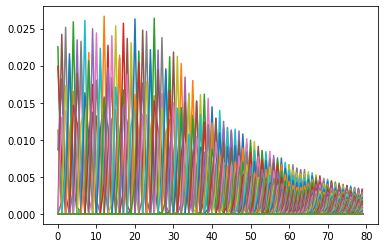

In [10]:
plt.plot(mel_basis[:,:])
plt.show()

# init

In [102]:
import torch
import librosa
import soundfile as sf
import numpy as np
import torch
import os,glob
import torchaudio.transforms as T

In [103]:
noisy_path = '../data/wav/noisy.wav'
estim_path = '../data/wav/estim.wav'
fft_size = 1024
nhfft = int(fft_size/2 + 1)
shift_size = 256
n_mels = 80

## WAV load

In [104]:
noisy, sr = librosa.load(noisy_path,sr=16000)
noisy = noisy[:-768] # 768 samples longer 
print(np.shape(noisy))
estim, sr = librosa.load(estim_path,sr=16000)
print(np.shape(estim))

(99810,)
(99810,)


## STFT

In [105]:
noisy_spec = librosa.stft(noisy,window='hann', n_fft=fft_size,hop_length=shift_size, win_length=None,center=False)
print(np.shape(noisy_spec))
estim_spec = librosa.stft(estim,window='hann', n_fft=fft_size,hop_length=shift_size, win_length=None,center=False)
print(np.shape(estim_spec))
nframe = np.shape(noisy_spec)[1]

(513, 386)
(513, 386)


## STFT -> mel

In [121]:
mel_basis = librosa.filters.mel(sr=sr, n_fft=fft_size, n_mels=n_mels)
print(np.shape(mel_basis))

noisy_mel = np.matmul(mel_basis,np.abs(noisy_spec))
estim_mel = np.matmul(mel_basis,np.abs(estim_spec))

print(np.shape(noisy_mel))
print(np.shape(estim_mel))
print(np.max(estim_mel))
print(np.min(noisy_mel))

(80, 513)
(80, 386)
(80, 386)
3.3411086
0.00031840353


## spectral reshaping

In [116]:
H = mel_basis
print(np.shape(H))
abs_H = np.abs(H)

(80, 513)


$$ P[m,l] = \sum^{N-1}_{k=0} |X[m,e^{j \omega k} ) H_l(e^{j \omega k})|^2, 0 \leq l \leq L-1 \tag{2}   $$

In [108]:
tilde_P = estim_mel
P = noisy_mel

print(np.shape(tilde_P))
print(np.shape(P))

(80, 386)
(80, 386)


$$ w[m,l] = \frac{\tilde{P}[m,l]}{P[m,l]}, \ 0 \leq l \leq L-1 \tag{6} $$

w[l,m]

In [109]:
w = tilde_P/P
print(np.shape(w))

(80, 386)


$$ \mu[m,k] = \frac{\sum^{L-1}_{l=0} w[m,l] | H_l(e^{j\omega_k}) }{\sum^{L-1}_{l=0} | H_l ( e^{j\omega_k})|} , 0 \leq k \leq N/2 -1, 0 \leq l \leq L-1 \tag{7} $$

In [117]:
mu = np.zeros((nhfft,nframe))
print(np.shape(mu))
eps = 1e-13

for m in range(nframe) : 
    for k in range(nhfft) : 
        numer = 0 
        denom = 0
        for l in range(n_mels):
            numer += w[l,m]*abs_H[l,k]
            denom += abs_H[l,k]
        mu[k,m] = numer/(denom+eps)
                        
print(mu[:10,:10])

(513, 386)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.01341571 0.00977432 0.01077057 0.03522457 0.39654815 0.7245221
  0.7912976  0.81205688 0.94292334 0.76040684]
 [0.01341571 0.00977432 0.01077057 0.03522457 0.39654815 0.7245221
  0.7912976  0.81205688 0.94292334 0.76040684]
 [0.01101473 0.00792039 0.00951004 0.03839839 0.39629315 0.79171105
  0.87959643 0.89675545 0.99862731 0.82181634]
 [0.00712139 0.00491413 0.00746601 0.04354491 0.39587966 0.90066181
  1.02277812 1.03409912 1.08895448 0.92139543]
 [0.00468594 0.00302159 0.00634786 0.04716749 0.38085412 0.9978777
  1.10897239 1.11664349 1.13179018 0.9580276 ]
 [0.00703941 0.00478744 0.00827107 0.04578418 0.31783037 1.05654629
  1.00797225 1.01918097 1.01862426 0.78788966]
 [0.00939287 0.00655328 0.01019428 0.04440088 0.2548066  1.11521484
  0.90697211 0.92171845 0.90545833 0.61775171]
 [0.01311581 0.01026695 0.01105228 0.0378348  0.1830718  0.8550581
  0.83158826 

In [114]:
print(mu[:10,:10])

[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.01341571 0.00977432 0.01077057 0.03522457 0.39654815 0.7245221
  0.7912976  0.81205688 0.94292334 0.76040684]
 [0.01341571 0.00977432 0.01077057 0.03522457 0.39654815 0.7245221
  0.7912976  0.81205688 0.94292334 0.76040684]
 [0.01101473 0.00792039 0.00951004 0.03839839 0.39629315 0.79171105
  0.87959643 0.89675545 0.99862731 0.82181634]
 [0.00712139 0.00491413 0.00746601 0.04354491 0.39587966 0.90066181
  1.02277812 1.03409912 1.08895448 0.92139543]
 [0.00468594 0.00302159 0.00634786 0.04716749 0.38085412 0.9978777
  1.10897239 1.11664349 1.13179018 0.9580276 ]
 [0.00703941 0.00478744 0.00827107 0.04578418 0.31783037 1.05654629
  1.00797225 1.01918097 1.01862426 0.78788966]
 [0.00939287 0.00655328 0.01019428 0.04440088 0.2548066  1.11521484
  0.90697211 0.92171845 0.90545833 0.61775171]
 [0.01311581 0.01026695 0.01105228 0.0378348  0.1830718  0.8550581
  0.83158826 0.8

$$ \tilde{X}[m,e^{j\omega k}) = \mu[m,k] X[m,e^{j \omega k}), 0 \leq k \leq N-1 \tag{9}$$

In [118]:
tilde_X = mu*noisy_spec
print(np.shape(tilde_X))
print(tilde_X[:10,:10])

(513, 386)
[[-0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j]
 [-8.58158152e-03-1.66828361e-02j  3.62504062e-02+1.12947309e-02j
  -4.44277510e-02+1.54476949e-02j  3.66640879e-02-1.13089871e-03j
  -5.06598453e-01-2.16919223e+00j  4.00243016e+00+4.25904716e+00j
  -2.68437270e+00-1.95638716e+00j -8.17627222e-01+2.03225856e+00j
   3.02971886e+00-4.78914181e+00j -1.30088593e+00+4.09684435e+00j]
 [ 1.02252636e-02-1.54303141e-02j -6.26266970e-02+2.68605040e-02j
   9.03245492e-02-1.44915919e-02j -2.52296667e-01-7.98540505e-02j
   3.72419953e+00+2.38523556e+00j -6.99983617e+00-8.34295718e+00j
   5.30945710e+00+1.04623965e+01j  1.91319436e+00-9.16786663e+00j
  -5.49249275e+00+1.08222596e+01j  3.31174403e+00-7.26331987e+0

In [119]:
noisy_inv = librosa.istft(tilde_X, hop_length=shift_size, win_length=fft_size, window='hann', center=False)
print(np.shape(noisy_inv))
sf.write('re_noisy.wav',noisy_inv,16000)

(99584,)
